In [1]:
import matplotlib as mpl 
mpl.use("pgf") 
pgf_with_rc_fonts = {
    "font.serif": [],
}

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.facecolor'] = 'w'

In [2]:
%load_ext autoreload
%autoreload 2
from experiment import Runner

In [3]:
exp_ML1M = Runner(dataset='ML1M', params={})

[46619] [exp] ML1M | window_size = 5000, n_epoch = 1
[46619] [exp] n_sample = 226310; 45262 (20%) + 22631 (10%) + 158417 (70%)
[46619] [exp] n_user = 6014, n_item = 3232


### prepare

In [4]:
# http://public.tableau.com/profile/chris.gerrard#!/vizhome/TableauColors/ColorPaletteswithRGBValues
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
          (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
          (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),   
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
          (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# [0, 255] -> [0.0, 1.0]
for i in range(len(colors)): 
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

In [10]:
def read_result(path):
    t_reco = t_update = MPR = 0.
    recalls = []

    with open(path) as f:
        lines = list(map(lambda l: float(l.rstrip()), f.readlines()))
        t_reco = lines[0]
        t_update = lines[1]
        MPR = lines[2]
        recalls = lines[3:]
            
    return {'t_reco': t_reco, 't_update': t_update, 'MPR': MPR, 'recalls': recalls}

### Try various learning rate on ML1M

In [33]:
iMF1 = read_result('results/claim-iMF/ML1M_iMF_5000_k40_reg001_eta0001.txt')
iMF2 = read_result('results/claim-iMF/ML1M_iMF_5000_k40_reg001_eta0003.txt')
iMF3 = read_result('results/claim-iMF/ML1M_iMF_5000_k40_reg001_eta0006.txt')
iMF4 = read_result('results/claim-iMF/ML1M_iMF_5000_k40_reg001_eta0030.txt')

popular = read_result('results/claim-iMF/ML1M_popular_5000.txt')
random = read_result('results/claim-iMF/ML1M_random_5000.txt')

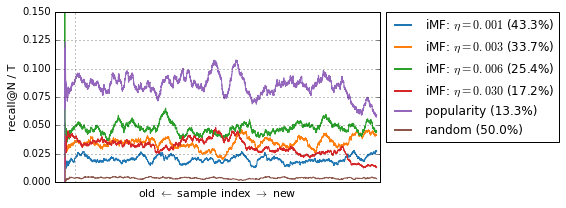

In [44]:
fig, ax = plt.subplots()

ax.plot(iMF1['recalls'], label=r'iMF: $\eta=0.001$ (%.1f%%)' % iMF1['MPR'], c=colors[0]) # epoch = 30
ax.plot(iMF2['recalls'], label=r'iMF: $\eta=0.003$ (%.1f%%)' % iMF2['MPR'], c=colors[2]) # epoch = 10
ax.plot(iMF3['recalls'], label=r'iMF: $\eta=0.006$ (%.1f%%)' % iMF3['MPR'], c=colors[4]) # epoch = 5
ax.plot(iMF4['recalls'], label=r'iMF: $\eta=0.030$ (%.1f%%)' % iMF4['MPR'], c=colors[6]) # epoch = 1

ax.plot(popular['recalls'], label=r'popularity (%.1f%%)' % popular['MPR'], c=colors[8])
ax.plot(random['recalls'], label=r'random (%.1f%%)' % random['MPR'], c=colors[10])

ax.set_xlabel(r'old $\leftarrow$ sample index $\rightarrow$ new', fontsize=11)
ax.set_ylabel('recall@N / T', fontsize=11)

T = 5000
ax.axvline(x=(T - 1), linewidth=1, linestyle=':', color=colors[14])

ax.set_xlim([-T, 160000])
ax.set_xticks([])

ax.set_ylim([0.0, 0.15])
ax.set_yticks([0.00, 0.025, 0.05, 0.075, 0.10, 0.125, 0.15])

legend = ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
for h in legend.legendHandles:
    h.set_linewidth(2.0)

ax.yaxis.grid()

fig.set_size_inches((5.5, 3))
fig.patch.set_alpha(0.0)
plt.tight_layout()

#### Observations

- Popularity is much better than iMF (also competitive to the best UserKNN result)
    - Hybrid method is important in a persistently cold-starting setting.
    - (balance between personalized and non-personalized method)
- Higher learning rate => better MPR
    - However, recall behavior does not correspond to MPR.
    - (i.e. iMF ($\eta=0.006$) is better than iMF ($\eta=0.030$) in terms of recall)
- Results are higly sensitive to learning rate
    - In a streaming environment, models may not be updated in a uniform pace.

### LastFM

In [49]:
lfm_iMF = read_result('results/claim-iMF/LastFM_iMF_5000_k20_reg001_eta003.txt')

lfm_popular = read_result('results/claim-iMF/LastFM_popular_5000.txt')

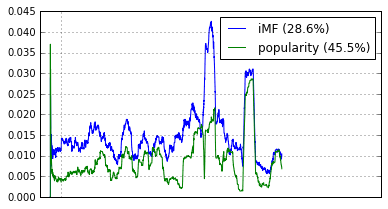

In [51]:
fig, ax = plt.subplots()

ax.plot(lfm_iMF['recalls'], label='iMF (%.1f%%)' % lfm_iMF['MPR'])
ax.plot(lfm_popular['recalls'], label='popularity (%.1f%%)' % lfm_popular['MPR'])

T = 5000
ax.axvline(x=(T - 1), linewidth=1, linestyle=':', color=colors[14])

ax.set_xlim([-T, 160000])
ax.set_xticks([])

ax.legend()

ax.yaxis.grid()

fig.set_size_inches((5.5, 3))
fig.patch.set_alpha(0.0)
plt.tight_layout()